# 60. 単語ベクトルの読み込みと表示

In [3]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
print(model['United_States'])

/Users/sugiyamaseiji/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


[-3.61328125e-02 -4.83398438e-02  2.35351562e-01  1.74804688e-01
 -1.46484375e-01 -7.42187500e-02 -1.01562500e-01 -7.71484375e-02
  1.09375000e-01 -5.71289062e-02 -1.48437500e-01 -6.00585938e-02
  1.74804688e-01 -7.71484375e-02  2.58789062e-02 -7.66601562e-02
 -3.80859375e-02  1.35742188e-01  3.75976562e-02 -4.19921875e-02
 -3.56445312e-02  5.34667969e-02  3.68118286e-04 -1.66992188e-01
 -1.17187500e-01  1.41601562e-01 -1.69921875e-01 -6.49414062e-02
 -1.66992188e-01  1.00585938e-01  1.15722656e-01 -2.18750000e-01
 -9.86328125e-02 -2.56347656e-02  1.23046875e-01 -3.54003906e-02
 -1.58203125e-01 -1.60156250e-01  2.94189453e-02  8.15429688e-02
  6.88476562e-02  1.87500000e-01  6.49414062e-02  1.15234375e-01
 -2.27050781e-02  3.32031250e-01 -3.27148438e-02  1.77734375e-01
 -2.08007812e-01  4.54101562e-02 -1.23901367e-02  1.19628906e-01
  7.44628906e-03 -9.03320312e-03  1.14257812e-01  1.69921875e-01
 -2.38281250e-01 -2.79541016e-02 -1.21093750e-01  2.47802734e-02
  7.71484375e-02 -2.81982

# 61. 単語の類似度

In [3]:
model.similarity('United_States', 'U.S.')

0.73107743

# 62. 類似度の高い単語10件

In [4]:
model.most_similar('United_States', topn=10)

[('Unites_States', 0.7877248525619507),
 ('Untied_States', 0.7541370391845703),
 ('United_Sates', 0.7400725483894348),
 ('U.S.', 0.7310774326324463),
 ('theUnited_States', 0.6404393911361694),
 ('America', 0.6178410053253174),
 ('UnitedStates', 0.6167312264442444),
 ('Europe', 0.6132988929748535),
 ('countries', 0.6044804453849792),
 ('Canada', 0.6019070148468018)]

# 63. 加法構成性によるアナロジー

In [5]:
model.most_similar(positive=['Spain', 'Athens'], negative=['Madrid'], topn=10)

[('Greece', 0.6898480653762817),
 ('Aristeidis_Grigoriadis', 0.560684859752655),
 ('Ioannis_Drymonakos', 0.555290937423706),
 ('Greeks', 0.5450686812400818),
 ('Ioannis_Christou', 0.5400862693786621),
 ('Hrysopiyi_Devetzi', 0.5248445272445679),
 ('Heraklio', 0.5207759141921997),
 ('Athens_Greece', 0.5168809294700623),
 ('Lithuania', 0.5166866183280945),
 ('Iraklion', 0.5146791934967041)]

# 64. アナロジーデータでの実験

In [8]:
input = 'questions-words.txt'
output = 'questions-words-with-word-cos.txt'

with open(input, "r") as input, \
    open(output, 'w') as output:
    for line in input:
        words = line.split()
        if words[0] == ':':
            category = words[1]
            continue
        word, cos = model.most_similar(positive=[words[1],words[2]], negative=[words[0]], topn=1)[0]
        output.write('{}\t{}\t{}\t{}\n'.format(category, line.rstrip(), word, cos))

# 65. アナロジータスクでの正解率

In [15]:
output = 'questions-words-with-word-cos.txt'

sem_cnt = 0
sem_true = 0
syn_cnt = 0
syn_true = 0

with open(output, "r") as f:
    for line in f:
        cols = line.strip().split('\t')
        target = cols[1].split()[-1]
        pred = cols[2]
        if not cols[0].startswith('gram'): #　文法的アナロジー
            sem_cnt += 1
            if target == pred:
                sem_true += 1
        
        else: #　意味的アナロジー
            syn_cnt += 1
            if target == pred:
                syn_true += 1
print("意味的アナロジー : {}".format(sem_true / sem_cnt))
print("文法的アナロジー : {}".format(syn_true / syn_cnt))

意味的アナロジー : 0.17352576389671892
文法的アナロジー : 0.2253864168618267


# 66. WordSimilarity-353での評価

In [18]:
from scipy.stats import spearmanr

human = []
vec = []
with open('combined.csv', 'r') as f:
    next(f)
    for line in f:
        words = line.rstrip().split(',')
        human.append(float(words[2]))
        vec.append(model.similarity(words[0], words[1]))

corr, value = spearmanr(human, vec)

print(corr)


0.7000166486272194


# 67. k-meansクラスタリング

In [1]:
file = 'questions-words-with-word-cos.txt'
category1 = ['capital-common-countries', 'capital-world']
category2 = ['currency', 'gram6-nationality-adjective']

countries = set()
with open(file, "r") as f:
    for row in f:
        cols = row.strip().split('\t')
        
        if cols[0] in category1:
            country = cols[1].split()[1]
            countries.add(country)

        elif cols[0] in category2:
            country = cols[1].split()[0]
            countries.add(country)
        
        else:
            continue

In [8]:
countries = list(countries)
country_vec = [model[country] for country in countries]

In [9]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=5)
kmeans.fit(country_vec)
for i in range(5):
    cluster = np.where(kmeans.labels_ == i)[0]
    print('cluster', i)
    print(','.join([countries[k] for k in cluster]))

cluster 0
Syria,Afghanistan,Libya,Iran,Egypt,Somalia,Lebanon,Pakistan,Jordan,Israel,Iraq
cluster 1
Albania,Kazakhstan,Latvia,Turkmenistan,Estonia,Bulgaria,Romania,Uzbekistan,Georgia,Tajikistan,Cyprus,Belarus,Macedonia,Montenegro,Ukraine,Lithuania,Azerbaijan,Moldova,Kyrgyzstan,Serbia,Turkey,Russia,Armenia
cluster 2
Iceland,Austria,Belgium,Malta,USA,Ireland,Finland,Spain,Denmark,Poland,Liechtenstein,Croatia,Norway,Italy,Switzerland,Germany,Sweden,Portugal,Uruguay,Netherlands,Slovenia,Argentina,Slovakia,France,Europe,Greece,England,Hungary,Canada
cluster 3
Malawi,Gambia,Zimbabwe,Rwanda,Mauritania,Botswana,Burundi,Namibia,Uganda,Morocco,Mozambique,Tunisia,Niger,Madagascar,Kenya,Gabon,Mali,Senegal,Zambia,Angola,Nigeria,Algeria,Guinea,Eritrea,Sudan,Liberia,Ghana
cluster 4
Thailand,Ecuador,Cuba,Bhutan,Guyana,Honduras,Taiwan,Nicaragua,Australia,Jamaica,Vietnam,Fiji,Cambodia,Chile,Laos,Philippines,Suriname,Oman,Greenland,India,Tuvalu,Bahamas,Bahrain,Qatar,Indonesia,Samoa,Mexico,Japan,Peru,Colom

# 68. Ward法によるクラスタリング

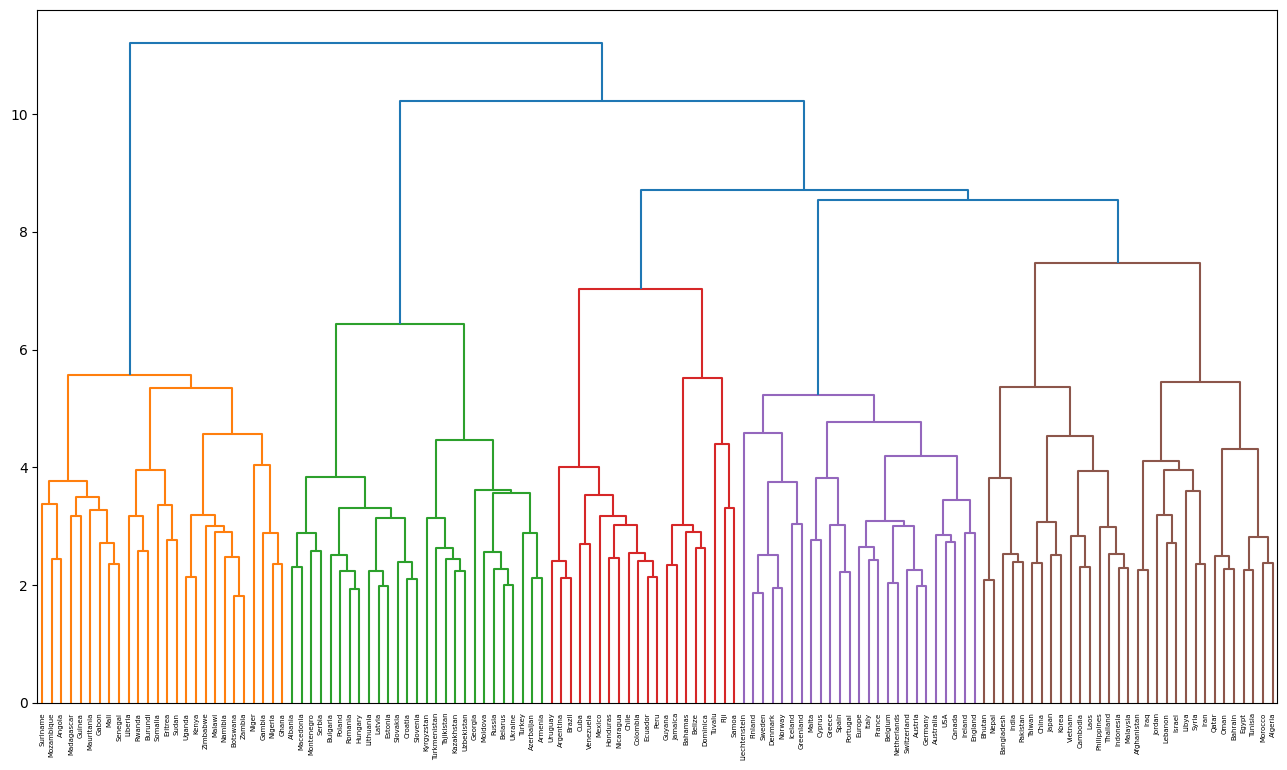

In [10]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

linkage_result = linkage(country_vec, method= 'ward')
plt.figure(figsize=(16, 9))
dendrogram(linkage_result, labels=countries)
plt.show()

# 69. t-SNEによる可視化

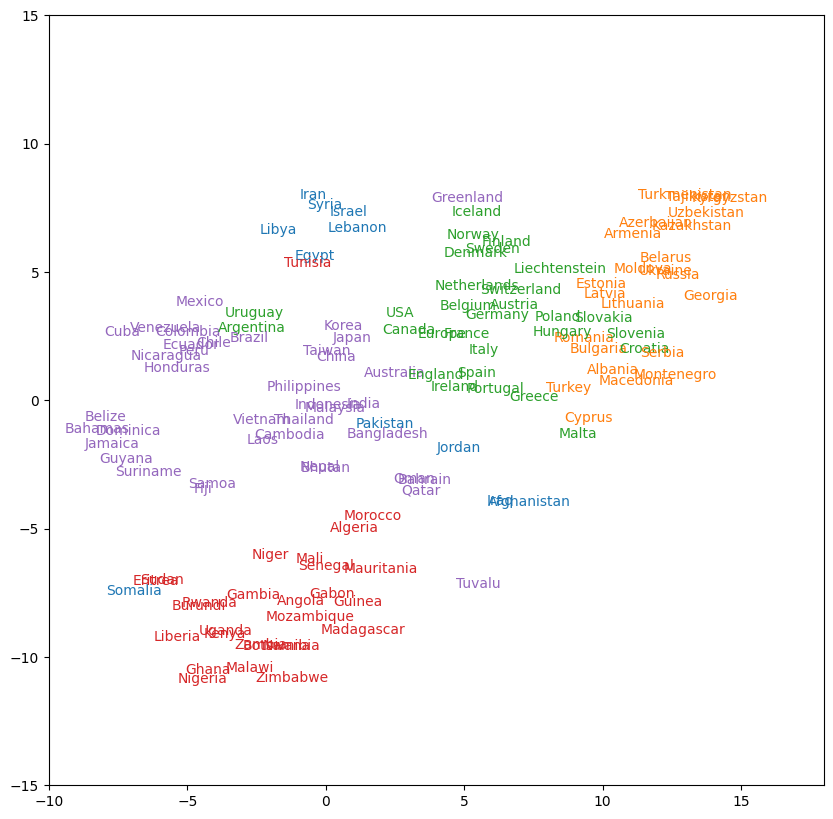

In [18]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=64)
X_reduced = tsne.fit_transform(np.array(country_vec))
plt.figure(figsize=(10, 10))
for x, country, color in zip(X_reduced, countries, kmeans.labels_):
    plt.text(x[0], x[1], country, color='C{}'.format(color))
plt.xlim([-10, 18])
plt.ylim([-15, 15])
plt.savefig('fig69.png')
plt.show()